In [1]:
options(warn=-1)
options(repr.plot.width=4, repr.plot.height=3)

library(IRdisplay)
display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Code">
 </form>'
)

# Modeling Response Rates

*Sebastian Daza*

I use the baseline dataset to explore which factors seems to predict attrition, and to identify potential biases of the data.

# Descriptives

Some descriptives to start. See code for details on the construction of variables

In [38]:
library(haven, warn.conflicts = FALSE, quietly=TRUE)
library(sdazar, warn.conflicts = FALSE, quietly=TRUE)
library(ggplot2, warn.conflicts = FALSE, quietly=TRUE)
library(ggthemes, warn.conflicts = FALSE, quietly=TRUE)
library(bayesplot, warn.conflicts = FALSE, quietly=TRUE)
library(StanCat, warn.conflicts = FALSE, quietly=TRUE)
library(psych, warn.conflicts = FALSE, quietly=TRUE)
library(brms, warn.conflicts = FALSE, quietly=TRUE)


In [39]:
path <- "/Users/sdaza/Dropbox/Projects/re-entry/10 investigadores/sdaza/data/baseline/baseline_08052017.dta"
b <- as.data.table(read_stata(path))

In [4]:
# rename variables
setnames(b, names(b), tolower(names(b)))
ovars <- c("folio_2", "p1", "p7", "p13", "p194", "p195")
nvars <- c("id", "age", "edu", "kids", "s_health", "s_mental_heath")
setnames(b, ovars, nvars)

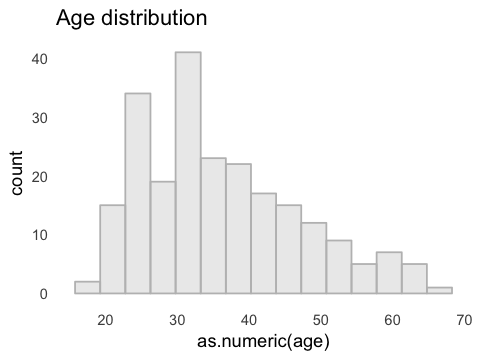

In [5]:
lb <- copy(b) # keep original version
ggplot(b, aes(x=as.numeric(age))) + geom_histogram(bins = 15, fill=I("grey"), col=I("grey"), alpha=0.3) +
    theme_minimal() + 
    labs(title = 'Age distribution')

In [6]:
# define variables

# self-reported health
vars <- c("s_health", "s_mental_heath")
dat <- assmis(b, list(vars), list(c(8,9)))

In [7]:
# kids binary
b[, any_kids := ifelse(kids > 0, 1, 0)]
#table(dat$s_mental_heath, useNA = "ifany")

In [8]:
# edu binary
b[, edu12 := ifelse(edu >= 12, 1, 0)] # cuarto medio +
#table(b$edu12, useNA = "ifany")

In [9]:
# mental health
vars <- lookvar(b, "salud")
b <- assmis(b, list(vars), list(c(8,9)))
# f <- fa(b[, vars, with = FALSE], nfactors = 4)
#summary(psych::alpha(as.data.frame(b[, vars, with = FALSE])))

In [10]:
b[, mental_health_score := rowscore(b, vars, type = "mean")]
#summary(b$mental_health_score)

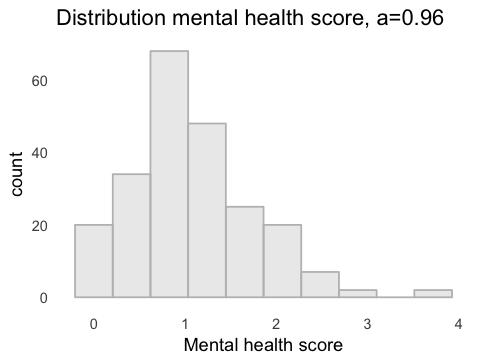

In [11]:
ggplot(b, aes(mental_health_score)) + geom_histogram(bins = 10, fill=I("grey"), col=I("grey"), alpha=0.3) +
    labs(x = "Mental health score", title = "Distribution mental health score, a=0.96") +
    theme_minimal()

In [12]:
# interviewer assessment (too many missing cases)
vars <- lookvar(b, "evaluar")
b <- assmis(b, list(vars), list(c(8,9)))
b[, interviewer_assessment := rowscore(b, vars, p = 0.01)]
#summary(b$interviewer_assessment)

In [ ]:
# housing
#table(b$p36, useNA = "ifany")

In [ ]:
b <- assmis(b, list("p36"), list(c(8,9)))
setnames(b, "p36", "residential_instability")

In [14]:
# employment
b[, employment := rowscore(b, c("p173", "p181"), type = "any", val = 1)]
#table(b$employment)
#table(b[, .(p173, p181)]) # formal and independent

In [15]:
# substance use issues
b <- assmis(b, list("p210"), list(c(8,9)))
#table(b$p210,  useNA = "ifany")
setnames(b, "p210", "drug_use_issues")
#table(b$drug_use_issues, useNA = "ifany")

In [16]:
# drug prevalence
b[, hard_drugs := as.numeric(p212_2_d %in% c(1,2) | p212_2_e %in% c(1,2))]
# b[, .(id, hard_drugs, p212_2_d, p212_2_e)]
#table(b$hard_drugs, useNA = "ifany")

In [17]:
# expectations to quit crime
#table(b$p262, useNA = "ifany")
b <- assmis(b, list(c("p262")), list(c(8,9)))
b <- revscale(b, "p262", "expect_crime")
#table(b$expect_crime, useNA = "ifany")

In [18]:
# crimes
#table(b$p137, useNA = "ifany")
b[p137 == 7 , crime := 2] # theft
b[p137 %in% c(1:6, 8:11), crime := 1] # robbery
b[p137 %in% c(15:16), crime := 3] # drugs
b[p137 %in% c(12:14, 17:24), crime := 1] # other
#table(b$crime, useNA = "ifany")
#prop.table(table(b$crime, useNA = "ifany"))

In [19]:
# sentence time
b <- assmis(b, list(c("p138_anos", "p138_dias", "p138_mese")), list(c(88,99)))
b[, sentence_time := sum(p138_anos * 365.25 + p138_mese * 30.5 + p138_dias, na.rm = TRUE), id]
# b[, .(id, sentence_time, p138_anos, p138_mese, p138_dias)]

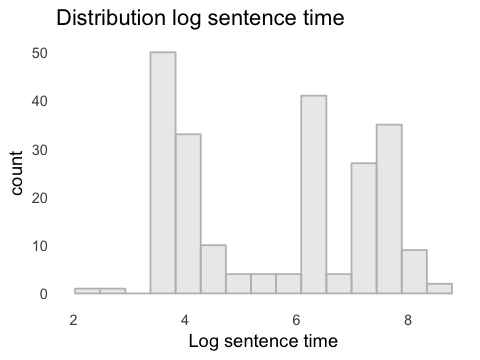

In [20]:
ggplot(b, aes(log(sentence_time))) + geom_histogram(bins = 15, fill=I("grey"), col=I("grey"), alpha=0.3) +
    theme_minimal() + 
    labs(x = "Log sentence time", title = "Distribution log sentence time")

In [21]:
# select variables
nvars <- c("id", "age", "edu12", "any_kids", "s_health", "s_mental_heath",
           "mental_health_score", "interviewer_assessment",
           "residential_instability", "employment", "sentence_time", "drug_use_issues",
           "hard_drugs", "expect_crime", "crime")

b <- b[, ..nvars]

In [22]:
r <- fread('/Users/sdaza/Google Drive/github/reentry-chile/reports/data/clean_register.csv')

In [23]:
# create interviewer id variable
r[, id_int := .GRP, interviewer]
#table(r$id_int, useNA = "ifany")

In [24]:
# merge cases 
setkey(b, id); setkey(r, id)
dat <- b[r]

In [25]:
# recode some variables for models
dat[, missing_week := ifelse(r_week == 1, 0, 1)]
dat[, missing_2months := ifelse(r_2months == 1, 0, 1)]
dat[, log_sentence_time := scale(log(sentence_time + 0.01), center = TRUE, scale = FALSE)]
dat[, z_age := scale(age)]
dat[, z_mental_health_score := scale(mental_health_score)]
dat[, z_residential_instability := scale(residential_instability)]
dat[, crime := factor(crime, labels = c("robbery + others", "theft", "drugs"))]
# dat[, crime := relevel(crime, ref = c("drugs"))]

In [26]:
# descriptives
summary(dat[, .(age, any_kids, edu12, mental_health_score, residential_instability)])

      age           any_kids          edu12        mental_health_score
 Min.   :19.00   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000     
 1st Qu.:27.00   1st Qu.:1.0000   1st Qu.:0.0000   1st Qu.:0.6346     
 Median :34.00   Median :1.0000   Median :0.0000   Median :0.9719     
 Mean   :36.12   Mean   :0.8933   Mean   :0.2889   Mean   :1.0703     
 3rd Qu.:42.00   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.4213     
 Max.   :68.00   Max.   :1.0000   Max.   :1.0000   Max.   :3.7191     
                                                   NA's   :1          
 residential_instability
 Min.   :1.000          
 1st Qu.:1.000          
 Median :1.000          
 Mean   :1.366          
 3rd Qu.:2.000          
 Max.   :4.000          
 NA's   :1              

# First week

Let's see first if there is variability of participation by interviewer. For this, I use Bayesian logistic random models. 

In [27]:
fit1 <- brm(missing_week ~+ (1|id_int),
            data = dat,  family = bernoulli(link = "logit"),
            control= list(adapt_delta=.99), refresh=0)

Compiling the C++ model
Start sampling



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.744025 seconds (Warm-up)
               0.660222 seconds (Sampling)
               1.40425 seconds (Total)


Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.852197 seconds (Warm-up)
               1.04671 seconds (Sampling)
               1.89891 seconds (Total)


Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.820443 seconds (Warm-up)
               0.748227 seconds (Sampling)
               1.56867 seconds (Total)


Gradient evaluation took 2.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your


Ensure that your parameter labels are in the same order as the parameters.



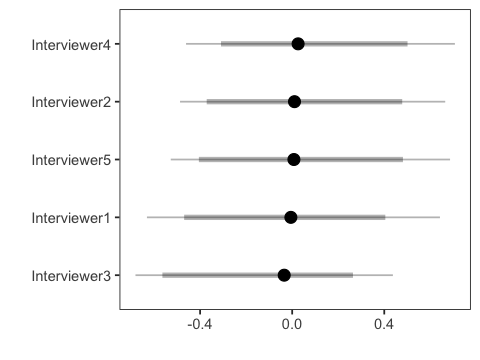

In [43]:
stan_caterpillar(fit1, pars = "^r",
                 pars_label = paste0("Interviewer", 1:5))

Not much going on here! What about preditors of the response?

In [29]:
fit2 <- brm(missing_week ~ z_age + any_kids + edu12 + z_mental_health_score +
                   z_residential_instability + employment + hard_drugs + crime +
                    log_sentence_time + (1|id_int),
                    data = dat,  family = bernoulli(link = "logit"),
                    control= list(adapt_delta=.99), refresh=0)

Compiling the C++ model
Start sampling



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.6006 seconds (Warm-up)
               1.20602 seconds (Sampling)
               2.80661 seconds (Total)


Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.92833 seconds (Warm-up)
               1.91408 seconds (Sampling)
               3.84241 seconds (Total)


Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.65139 seconds (Warm-up)
               2.12854 seconds (Sampling)
               3.77993 seconds (Total)


Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expec

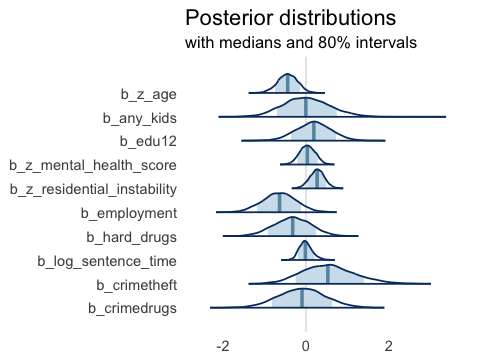

In [30]:
posterior <- as.matrix(fit2)
plot_title <- ggtitle("Posterior distributions",
                      "with medians and 80% intervals")
mcmc_areas(posterior,
           regex_pars = c("z_age", "any_kids", "edu12", "z_mental_health_score",
                    "z_residential_instability", "employment", "hard_drugs",
                    "log_sentence_time", "crime"),
           prob = 0.8) + plot_title + theme_minimal()

Age, employment and residential stability seem to be key factors here, although the marginal effects are not that big.

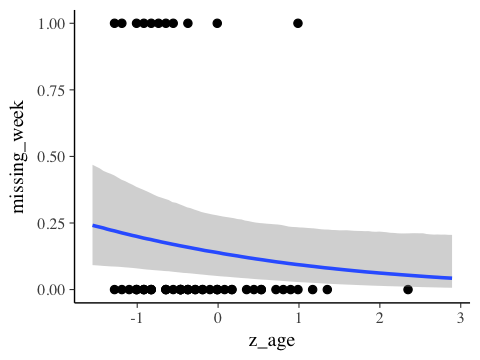

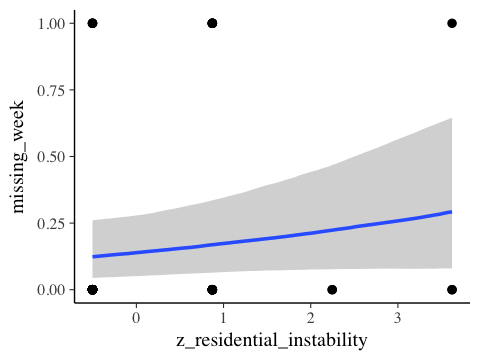

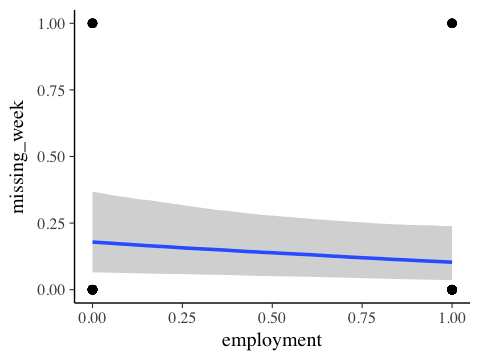

In [31]:
eff <- c("z_age", "z_residential_instability", "employment")
plot(marginal_effects(fit2, effects = eff, re_formula = NA, spaghetti = FALSE),
  points = TRUE, jitter_width = 0, ask = FALSE)

# Two months

Let's explore the same but this time modeling the two-month response rate. We see more variability by interviewer.

In [32]:
fit3 <- brm(missing_2months ~+ (1|id_int),
                   data = dat,  family = bernoulli(link = "logit"),
                   control= list(adapt_delta=.99), refresh=0)

Compiling the C++ model
Start sampling



Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.928618 seconds (Warm-up)
               1.02063 seconds (Sampling)
               1.94925 seconds (Total)


Gradient evaluation took 3.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.01606 seconds (Warm-up)
               1.13366 seconds (Sampling)
               2.14973 seconds (Total)


Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.03971 seconds (Warm-up)
               0.887088 seconds (Sampling)
               1.9268 seconds (Total)


Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your exp


Ensure that your parameter labels are in the same order as the parameters.



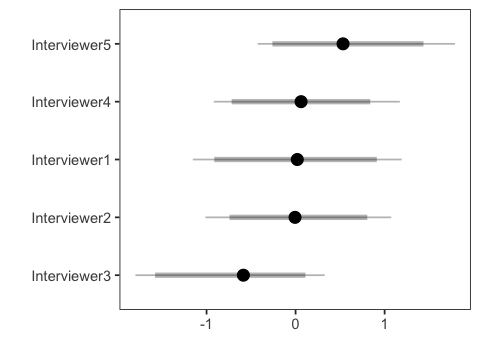

In [33]:
stan_caterpillar(fit3, pars = "^r",
                 pars_label = paste0("Interviewer", 1:5))

Using predictors... 

In [34]:
fit4 <- brm(missing_2months ~ z_age + any_kids + edu12 +  z_mental_health_score +
                   z_residential_instability + employment + hard_drugs
                   + crime + log_sentence_time + (1|id_int),
                   data = dat,  family = bernoulli(link = "logit"),
                   control= list(adapt_delta=.99), refresh=0)

Compiling the C++ model
Start sampling



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.78462 seconds (Warm-up)
               2.34408 seconds (Sampling)
               5.1287 seconds (Total)


Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2.1415 seconds (Warm-up)
               3.11413 seconds (Sampling)
               5.25563 seconds (Total)


Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.79576 seconds (Warm-up)
               2.34707 seconds (Sampling)
               4.14283 seconds (Total)


Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectati

Same patterns, although noisier estimates. Non-response, as expected, is not random and we will need to correct potential biases by imputing or weighting.

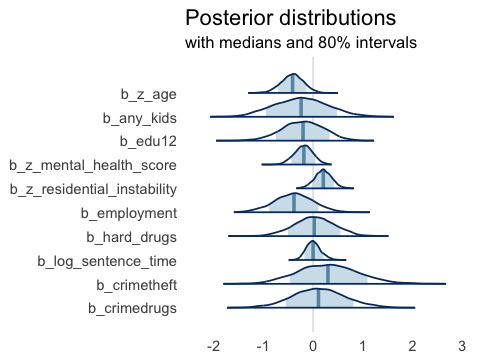

In [36]:
posterior <- as.matrix(fit4)
plot_title <- ggtitle("Posterior distributions",
                      "with medians and 80% intervals")

mcmc_areas(posterior,
           regex_pars = c("z_age", "any_kids", "edu12", "z_mental_health_score",
                    "z_residential_instability", "employment", "hard_drugs",
                    "log_sentence_time", "crime"),
           prob = 0.8) + plot_title + theme_minimal()

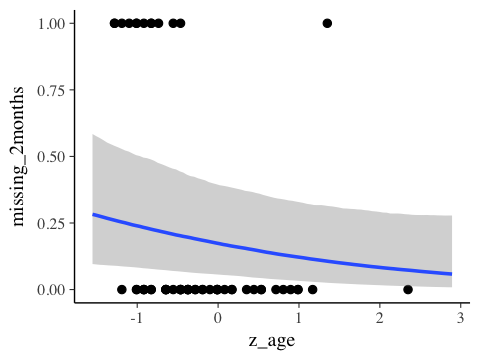

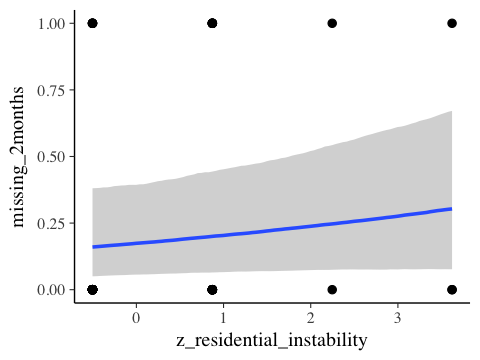

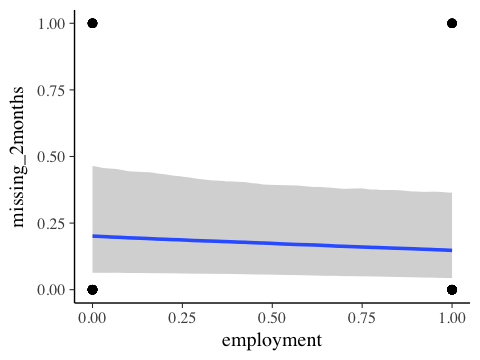

In [37]:
eff <- c("z_age", "z_residential_instability", "employment")
plot(marginal_effects(fit4, effects = eff, re_formula = NA, spaghetti = FALSE),
  points = TRUE, jitter_width = 0, ask = FALSE)